In [ ]:
!pip install torch pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 35.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from torch.distributions import constraints
import numpy as np

In [ ]:
import pandas as pd
data = pd.read_csv('heart_disease_uci.csv')

In [ ]:
data.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
df = data.copy()
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for column in ['cp', 'restecg', 'slope', 'thal']:
    df[column] = label_encoder.fit_transform(df[column])

In [ ]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,3,145.0,233.0,True,0,150.0,False,2.3,0,0.0,0,0
1,2,67,Male,Cleveland,0,160.0,286.0,False,0,108.0,True,1.5,1,3.0,1,1
2,3,67,Male,Cleveland,0,120.0,229.0,False,0,129.0,True,2.6,1,2.0,2,1
3,4,37,Male,Cleveland,2,130.0,250.0,False,1,187.0,False,3.5,0,0.0,1,0
4,5,41,Female,Cleveland,1,130.0,204.0,False,0,172.0,False,1.4,2,0.0,1,0


In [ ]:
df.shape

(920, 16)

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(303, 16)

In [ ]:
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)
df['fbs'] = df['fbs'].astype(int)
df['exang'] = df['exang'].astype(int)

<ipython-input-12-310015843dec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)
<ipython-input-12-310015843dec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fbs'] = df['fbs'].astype(int)
<ipython-input-12-310015843dec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
df = df.drop(columns = ['id', 'dataset'])

In [ ]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0.0,0,0
1,67,1,0,160.0,286.0,0,0,108.0,1,1.5,1,3.0,1,1
2,67,1,0,120.0,229.0,0,0,129.0,1,2.6,1,2.0,2,1
3,37,1,2,130.0,250.0,0,1,187.0,0,3.5,0,0.0,1,0
4,41,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0.0,1,0
5,56,1,1,120.0,236.0,0,1,178.0,0,0.8,2,0.0,1,0
6,62,0,0,140.0,268.0,0,0,160.0,0,3.6,0,2.0,1,1
7,57,0,0,120.0,354.0,0,1,163.0,1,0.6,2,0.0,1,0
8,63,1,0,130.0,254.0,0,0,147.0,0,1.4,1,1.0,2,1
9,53,1,0,140.0,203.0,1,0,155.0,1,3.1,0,0.0,2,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['num'])
y = df['num']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_clean, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

In [ ]:
X_clean = torch.tensor(X_clean, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Add Noise

In [ ]:
def add_noise_to_data(X, noise_factor=0.8, outlier_fraction = 0.1, outlier_scale=5):
    noise = noise_factor * torch.randn_like(X)
    X_noisy = X + noise
    X_noisy = torch.clamp(X_noisy, 0, 1)

    num_outliers = int(outlier_fraction * X.shape[0])  # Determine number of outlier points
    outlier_indices = torch.randint(0, X.shape[0], (num_outliers,))  # Randomly select outlier positions
    X_outliers = torch.randn_like(X[outlier_indices]) * outlier_scale  # Scale up for extreme values
    X_noisy[outlier_indices] = X_outliers
    return X_noisy

X_train = add_noise_to_data(X_clean, noise_factor = 0.8, outlier_fraction=0.05)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([272, 13])
X_test shape: (31, 13)
y_train shape: torch.Size([272])
y_test shape: (31,)


In [ ]:
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [ ]:
pyro.clear_param_store()

In [ ]:
def model_MVN(X, y):
    w_prior = dist.MultivariateNormal(torch.zeros(X.shape[1]), torch.eye(X.shape[1]))  # Multivariate Normal for weights
    b_prior = dist.Normal(0., 1.)  # Normal prior for the bias

    # Sample weights and bias from the priors
    w = pyro.sample('w_MVN', w_prior)
    b = pyro.sample('b_MVN', b_prior)

    # Linear model: w * X + b
    logits = torch.matmul(X, w) + b
    probs = torch.sigmoid(logits)  # Sigmoid activation for binary classification

    # Likelihood: Bernoulli distribution for the binary target
    with pyro.plate('data', X.shape[0]):  # Plate to represent the batch dimension
        pyro.sample('obs', dist.Bernoulli(probs), obs=y)


def guide_MVN(X, y):
    # Define variational parameters for the weights and bias
    # Variational parameters for weights and bias
    w_loc = pyro.param('w_loc_MVN', torch.randn(X.shape[1]))  # Mean of variational distribution for weights
    w_scale = pyro.param('w_scale_MVN', torch.ones(X.shape[1]), constraint=torch.distributions.constraints.positive)  # Scale of variational distribution for weights
    b_loc = pyro.param('b_loc_MVN', torch.randn(1))  # Mean of variational distribution for bias
    b_scale = pyro.param('b_scale_MVN', torch.ones(1), constraint=torch.distributions.constraints.positive)  # Scale of variational distribution for bias

    # Variational distribution for the weights: Multivariate Normal
    # Using a diagonal covariance matrix for the variational distribution (for simplicity)
    w_cov = torch.diag(w_scale)  # Covariance matrix for the variational distribution
    pyro.sample('w_MVN', dist.MultivariateNormal(w_loc, w_cov))  # Multivariate Normal for weights

    # Variational distribution for the bias
    pyro.sample('b_MVN', dist.Normal(b_loc, b_scale))  # Normal for bias


# Optimizer setup
adam_params = {"lr": 0.01}
optimizer = pyro.optim.Adam(adam_params)

# SVI setup
svi_MVN = SVI(model_MVN, guide_MVN, optimizer, loss=Trace_ELBO())

# Train the model with Stochastic Variational Inference (SVI)
num_steps = 5000
for step in range(num_steps):
    loss = svi_MVN.step(X_train, y_train)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")


Step 0, Loss: 436.2348793745041
Step 100, Loss: 354.1954920887947
Step 200, Loss: 262.6305920481682
Step 300, Loss: 263.0586168766022
Step 400, Loss: 234.37539517879486
Step 500, Loss: 239.57586443424225
Step 600, Loss: 202.4210866689682
Step 700, Loss: 209.902379155159
Step 800, Loss: 205.48812371492386
Step 900, Loss: 192.1460406780243
Step 1000, Loss: 199.62867903709412
Step 1100, Loss: 196.40174853801727
Step 1200, Loss: 196.21401119232178
Step 1300, Loss: 192.1605759859085
Step 1400, Loss: 190.0043956041336
Step 1500, Loss: 198.72685527801514
Step 1600, Loss: 191.58026266098022
Step 1700, Loss: 187.70571625232697
Step 1800, Loss: 192.22498893737793
Step 1900, Loss: 190.78959012031555
Step 2000, Loss: 188.62058860063553
Step 2100, Loss: 187.13860201835632
Step 2200, Loss: 189.94923973083496
Step 2300, Loss: 188.15407222509384
Step 2400, Loss: 188.44259357452393
Step 2500, Loss: 192.4720515012741
Step 2600, Loss: 191.93940567970276
Step 2700, Loss: 191.69162613153458
Step 2800, Loss

In [ ]:
def model_T(X, y):
    # Define priors
    df = pyro.sample("df", dist.Gamma(2.0, 1.0))
    w_prior = dist.StudentT(df=df, loc=torch.zeros(X.shape[1]), scale=torch.ones(X.shape[1]))
    b_prior = dist.StudentT(df=df, loc=torch.zeros(1), scale=torch.ones(1))

    # Sample weights and bias from the priors
    w = pyro.sample('w_T', w_prior.to_event(1))
    b = pyro.sample('b_T', b_prior)

    # Linear model: w * X + b
    logits = torch.matmul(X, w) + b
    probs = torch.sigmoid(logits)

    # Likelihood: Bernoulli distribution for the binary target
    with pyro.plate('data', X.shape[0]):
        pyro.sample('obs', dist.Bernoulli(probs), obs=y)



def guide_T(X, y):
    # Define variational parameters for the weights and bias
    df_loc = pyro.param("df_loc", torch.tensor(2.0), constraint=dist.constraints.positive)
    w_loc = pyro.param('w_loc_T', torch.randn(X.shape[1]))
    w_scale = pyro.param('w_scale_T', torch.ones(X.shape[1]), constraint=torch.distributions.constraints.positive)
    b_loc = pyro.param('b_loc_T', torch.randn(1))
    b_scale = pyro.param('b_scale_T', torch.ones(1), constraint=torch.distributions.constraints.positive)

    # Variational distributions for the weights and bias
    pyro.sample("df", dist.Gamma(df_loc, torch.tensor(1.0)))
    pyro.sample('w_T', dist.StudentT(df=df_loc, loc=w_loc, scale=w_scale).to_event(1))
    pyro.sample('b_T', dist.StudentT(df=df_loc, loc=b_loc, scale=b_scale))



adam_params = {"lr": 0.01}
optimizer = pyro.optim.Adam(adam_params)

# SVI setup
svi_T = SVI(model_T, guide_T, optimizer, loss=Trace_ELBO())
# Train the model with Stochastic Variational Inference (SVI)
num_steps = 5000
for step in range(num_steps):
    loss = svi_T.step(X_train, y_train)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")

Step 0, Loss: 780.2435946464539
Step 100, Loss: 448.7678359746933
Step 200, Loss: 316.76175260543823
Step 300, Loss: 256.29193034768105
Step 400, Loss: 230.46514123678207
Step 500, Loss: 226.7635338306427
Step 600, Loss: 197.15414199233055
Step 700, Loss: 202.83169960975647
Step 800, Loss: 197.4132255613804
Step 900, Loss: 186.74875302612782
Step 1000, Loss: 195.60568976402283
Step 1100, Loss: 197.67696921527386
Step 1200, Loss: 193.50450840592384
Step 1300, Loss: 200.7530226111412
Step 1400, Loss: 188.73480772972107
Step 1500, Loss: 189.0765302181244
Step 1600, Loss: 186.6673064827919
Step 1700, Loss: 186.12438035011292
Step 1800, Loss: 188.64234399795532
Step 1900, Loss: 188.7160416841507
Step 2000, Loss: 186.54918438196182
Step 2100, Loss: 189.56912505626678
Step 2200, Loss: 194.5119805932045
Step 2300, Loss: 190.11777794361115
Step 2400, Loss: 194.25639581680298
Step 2500, Loss: 191.5966591835022
Step 2600, Loss: 190.43685460090637
Step 2700, Loss: 194.72287273406982
Step 2800, Los

In [ ]:
T_df_param = pyro.param("df_loc").detach().item()
T_scale_param_tensor = pyro.param('w_scale_T').detach()
T_mean_param_tensor = pyro.param('w_loc_T').detach()
T_bias_mean_param = pyro.param('b_loc_T').detach()
T_bias_scale_param = pyro.param('b_scale_T').detach()
MVN_scale_param_tensor = pyro.param('w_scale_MVN').detach()
MVN_mean_param_tensor = pyro.param('w_loc_MVN').detach()
MVN_bias_mean_param = pyro.param('b_loc_MVN').detach()
MVN_bias_scale_param = pyro.param('b_scale_MVN').detach()
r = np.diag(T_scale_param_tensor.numpy())

In [ ]:
r.shape

(13, 13)

In [ ]:
vi_posterior_t = [dist.StudentT(pyro.param("df_loc").detach().item(), pyro.param('w_loc_T').detach()[i], pyro.param('w_scale_T').detach()[i])for i in range(13)]
vi_posterior = dist.MultivariateNormal(loc = pyro.param('w_loc_MVN').detach(), covariance_matrix= torch.diag(pyro.param('w_scale_MVN').detach()))

# Pseudo BMA and Stacking for optimal weights

In [ ]:
import arviz as az
import pymc as pm

In [ ]:
rng = np.random.seed(2741)

In [ ]:
# Model 1: Multivariate Normal
with pm.Model() as model_mvnorm:
    # Priors (extracting from vi_posterior)
    intercept = pm.Normal('intercept', mu= MVN_bias_mean_param.numpy()[0], sigma= MVN_bias_scale_param.numpy()[0])
    coefs = pm.MvNormal('coefs', mu=vi_posterior.loc[0:].numpy(), cov=vi_posterior.covariance_matrix[:, :].numpy())


    # Logistic regression
    logits = pm.invlogit(intercept + pm.math.dot(X_train.numpy(), coefs))
    likelihood = pm.Bernoulli('likelihood', logit_p=logits, observed=y_train.numpy())

    idata_0 = pm.sample(draws=2000, tune=1000, target_accept=0.99, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_0, extend_inferencedata=True, random_seed=rng)

Output()

Output()

array([[<Axes: title={'center': 'coefs'}>,
        <Axes: title={'center': 'coefs'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

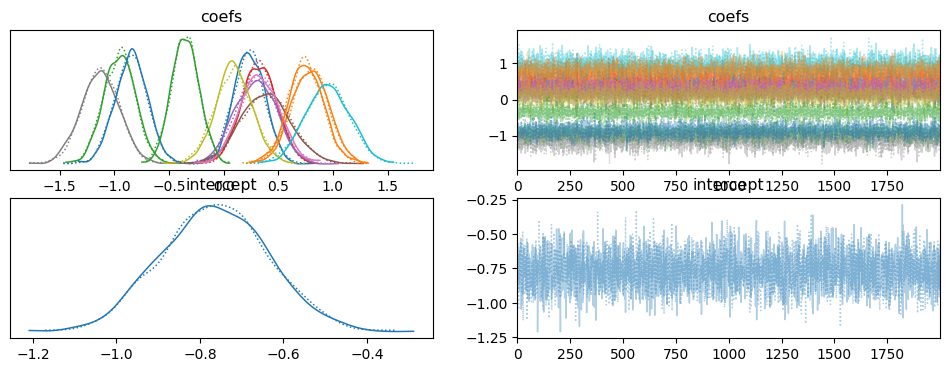

In [ ]:
pm.plot_trace(idata_0)

In [ ]:
# Model 2: Student T
with pm.Model() as model_studentt:
    # Priors (extracting from vi_posterior_t)
    intercept = pm.StudentT('intercept', mu= T_bias_mean_param.numpy()[0], sigma= T_bias_scale_param.numpy()[0], nu=T_df_param)
    coefs = pm.MvStudentT("coefs",mu=T_mean_param_tensor.numpy(),scale=r,nu=T_df_param)

    # Logistic regression
    logits = pm.invlogit(intercept + pm.math.dot(X_train.numpy(), coefs))
    likelihood = pm.Bernoulli('likelihood', logit_p=logits, observed=y_train.numpy())

    idata_1 = pm.sample(draws=2000, tune=1000, target_accept=0.99, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_1, extend_inferencedata=True, random_seed=rng)


Output()

Output()

array([[<Axes: title={'center': 'coefs'}>,
        <Axes: title={'center': 'coefs'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

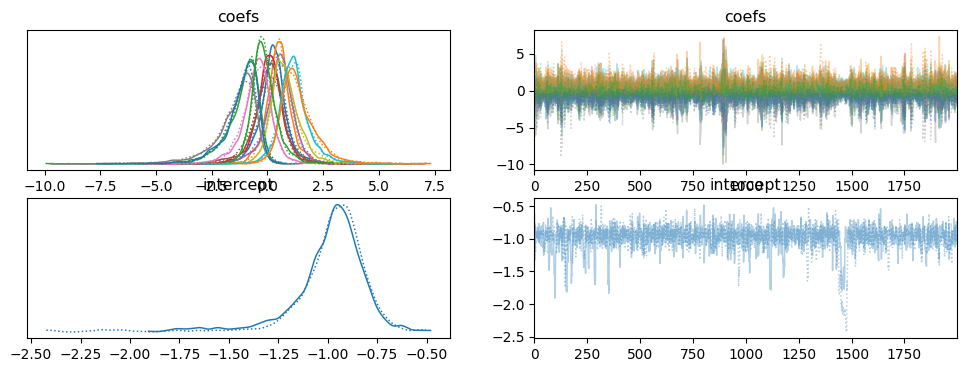

In [ ]:
pm.plot_trace(idata_1)

In [ ]:
model_dict = dict(zip(["model_mvnorm", "model_studentt"], [idata_0, idata_1]))
comp = az.compare(model_dict, method = "BB-Pseudo-BMA")
comp

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1045: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more lik

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_studentt,0,-180.641669,1.821990,0.000000,0.8265,3.372576,0.000000,True,log
model_mvnorm,1,-182.466673,0.451849,1.825003,0.1735,3.567190,0.916589,True,log


# Test Accuracy

In [ ]:
def predict_testset(X, num_samples=4000, w1=comp.loc['model_studentt', 'weight'], w2=comp.loc['model_mvnorm', 'weight']):
    # Student-T parameters
    df_loc = T_df_param
    w_loc_T = pyro.param('w_loc_T')
    w_scale_T = pyro.param('w_scale_T')
    b_loc_T = pyro.param('b_loc_T')

    # MVN parameters
    w_loc_MVN = pyro.param('w_loc_MVN')
    w_cov_MVN = torch.diag(pyro.param('w_scale_MVN'))
    b_loc_MVN = pyro.param('b_loc_MVN')
    b_scale_MVN = pyro.param('b_scale_MVN')

    # Sample mixture components
    mix_component = torch.bernoulli(torch.full((num_samples,), w1))  # Choose component
    mix_component_copy = mix_component.clone()

    # Sample weights directly from mixture model
    w_samples = torch.where(
        mix_component[:, None] == 1,
        dist.StudentT(df=df_loc, loc=w_loc_T, scale=w_scale_T).sample((num_samples,)),
        dist.MultivariateNormal(w_loc_MVN, w_cov_MVN).sample((num_samples,))
    )


    b_T_samples = dist.StudentT(df=df_loc, loc=b_loc_T, scale=torch.ones(1)).sample((num_samples,))
    b_MVN_samples = dist.Normal(b_loc_MVN, b_scale_MVN).sample((num_samples,))
    b_samples = torch.where(mix_component_copy[:, None] == 1, b_T_samples, b_MVN_samples)  # Ensure shape remains (2000,)

    # Compute logits
    logits = torch.matmul(X, w_samples.T) + b_samples.T
    probs = torch.sigmoid(logits).mean(dim=1)  # Average predictions

    return (probs > 0.5).float()  # Return binary predictions

In [ ]:
y_pred = predict_testset(X_test)
accuracy = (y_pred == y_test).float().mean()
print(f"Accuracy: {accuracy.item() * 100:.4f}%")

Accuracy: 67.7419%


# SVI Accuracy

In [ ]:
def predict(X, num_samples = 4000):
    # Get the learned parameters from the guide
    w_loc = pyro.param('w_loc_MVN')  # Mean of the weights
    w_cov = torch.diag(pyro.param('w_scale_MVN'))  # Covariance of the weights (diagonal for simplicity)
    b_loc = pyro.param('b_loc_MVN')  # Mean of the bias
    b_scale = pyro.param('b_scale_MVN')  # Std dev of the bias
    prob_samples = []
    for i in range(num_samples):
        # Sample from the variational distribution of w and b (posterior predictive sampling)
        w = dist.MultivariateNormal(w_loc, w_cov).sample()  # Sample weights
        b = dist.Normal(b_loc, b_scale).sample()  # Sample bias

        # Make predictions using the logistic model
        logits = torch.matmul(X, w) + b
        probs = torch.sigmoid(logits)
        prob_samples.append(probs)
    prob_samples = torch.stack(prob_samples)
    probs = prob_samples.mean(dim=0)
    return (probs > 0.5).float()  # Return binary predictions

# Predict on test data
y_pred_MVN = predict(X_test)

# Evaluate accuracy
accuracy = (y_pred_MVN == y_test).float().mean()
print(f"Accuracy: {accuracy.item() * 100:.4f}%")

Accuracy: 77.4194%
